## Experiment to test how well G2G captures different alignment patterns

Here we simulate (1) totally matched patterns using sampled functions from a Gaussian Process with RBF kernel, as well as (2) convergent (3) divergent (4) crossing patterns using a change point kernel by Penfold et al (2018), Wilson (2013), implemented based on standard textbook learnings on GPs and change point kernels. 

In [1]:
import torch
import gpytorch
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import pickle
import anndata
import os,sys,inspect
# setting the path to source
# sys.path.insert(0,os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))) + '/source') 
sys.path.append('source') 
# new source imports 
import Main
import ClusterUtils
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
torch.cuda.is_available() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1)

In [2]:
def run_G2G(simulated_datasets,T_f, use_const_std=False):
    # if const_std mode, G2G uses a constant of std=0.1 for all time points 
    n_sim_genes = len(simulated_datasets) 
    r_df = []
    q_df = []
    time = T_f.detach().numpy()
    
    for dataset in simulated_datasets:
        r_df.append( dataset[0])
        q_df.append( dataset[1])
    r_df = pd.DataFrame(r_df).transpose() 
    q_df = pd.DataFrame(q_df).transpose() 
    r_df.columns = np.asarray(['Gene' + str(x) for x in np.arange(n_sim_genes)]) 
    q_df.columns = r_df.columns
    gene_list = list(r_df.columns)

    aligner = Main.RefQueryAligner(r_df,time, q_df, time, gene_list, 50)
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.CONST_STD=use_const_std
    aligner.align_all_pairs()
    
    return aligner

def plot_simulated_dataset(simulated_dataset, T_f, figsize = (15,3)):
    l = len(simulated_dataset)
    ncol = 4
    nrow = int(np.ceil(l/ncol)) 
    plt.subplots(nrow,ncol,figsize=figsize) 
    k=1
    for pair in simulated_dataset:
        plt.subplot(nrow,ncol,k)
        sb.scatterplot(T_f,pair[0], color='midnightblue')
        sb.scatterplot(T_f,pair[1], color='forestgreen')
        k=k+1

## All Matches simulator

Random Sampling a reference and query instance of a function under a Gaussian Process

In [3]:
def generate_matched_functions(f, base_mean, base_kernel, σ = 0.1):
    sample1 = gpytorch.distributions.MultivariateNormal(f, (σ**2)*torch.eye(len(f))).rsample()
    sample2 = gpytorch.distributions.MultivariateNormal(f, (σ**2)*torch.eye(len(f))).rsample()
    return sample1,sample2

def run_all_match_simuator(T_f, n_simulations,base_mean_factor = 0.0):

    base_mean = torch.zeros(len(T_f)) + base_mean_factor
    base_kernel = gpytorch.kernels.RBFKernel(); base_kernel = gpytorch.lazy.NonLazyTensor(base_kernel(T_f).evaluate())
    f = gpytorch.distributions.MultivariateNormal(base_mean,base_kernel).rsample()
    
    matched_datasets = []
    for i in tqdm(range(n_simulations)):
        # sample random variation 
        σ = np.random.uniform(0.05,1.0)
        sample1,sample2 = generate_matched_functions(f, base_mean, base_kernel,σ)
        dataset = [sample1.detach().numpy(), sample2.detach().numpy()]
        matched_datasets.append(dataset)
    return matched_datasets

T_f = torch.tensor(np.linspace(0,1,300,dtype=np.float64)) # specify time points 
matched_datasets = run_all_match_simuator(T_f, n_simulations=100)
#plot_simulated_dataset(matched_datasets, T_f, figsize=(15,15))

100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

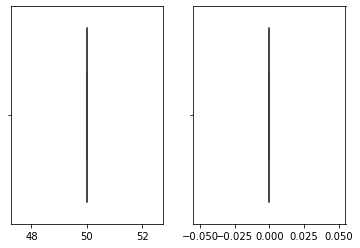

In [118]:
def run_match_experiment(matched_datasets, const_std_mode = False):
    
    aligner_matched = run_G2G(matched_datasets, T_f, const_std_mode)
    total_match_count_dist = [a.alignment_str.count('M') +a.alignment_str.count('W') + a.alignment_str.count('V')  for a in aligner_matched.results]
    total_mismatch_count_dist = [a.alignment_str.count('I') + a.alignment_str.count('D')  for a in aligner_matched.results]
    plt.subplots(1,2)
    plt.subplot(1,2,1)
    sb.boxplot(total_match_count_dist) 
    plt.subplot(1,2,2)
    sb.boxplot(total_mismatch_count_dist) 

    return aligner_matched, total_match_count_dist,total_mismatch_count_dist
    
aligner_matched, total_match_count_dist,total_mismatch_count_dist = run_match_experiment(matched_datasets, const_std_mode=False)

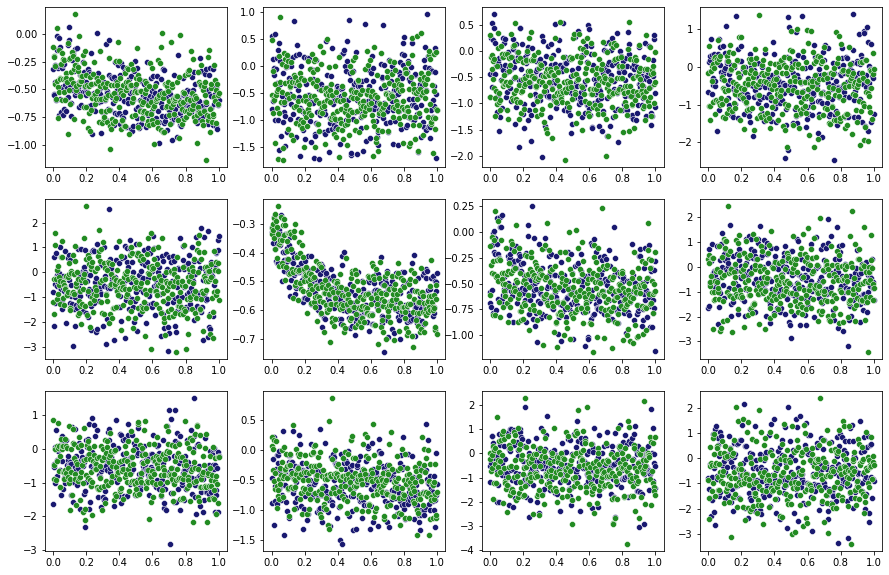

In [76]:
plot_simulated_dataset(matched_datasets[10:22], T_f, figsize=(15,10))

## Divergence and Convergence simulator

#### Implementing the HGP Branching Process with change point kernel by Penfold et al (2018)
Following is my attempt to implement the HGP based branching process to simulate a branching time series (10/11/2021)

In [5]:
# ========================================================================================================================
class ZeroKernel(gpytorch.kernels.Kernel):
    
    def __init__(self,**kwargs):
        super(ZeroKernel, self).__init__(**kwargs) 
        
    def forward(self,x1,x2,**kwargs):
        return torch.zeros(len(x1),len(x2))
    
#class ChangePointKernel(gpytorch.kernels.Kernel): TODO
    
def ChangePointKernel(K1,K2,T_f,t_cp,s):
    
    K1 = K1(T_f).evaluate().detach().numpy()
    K2 = K2(T_f).evaluate().detach().numpy()
    T_f = T_f.detach().numpy()
    
    def a(t,t_cp): # sigmoid function
        s=30# steepness - this controls how steep the bifurcation point (seems a high value is suitable for the 0-1 range from testing)
        return 1/(1+np.exp((t_cp-t)*s)) #return 0.5 * (1.0 + np.tanh((t_b-t)/s))
    
    CP = np.zeros([len(T_f),len(T_f)])
    for i in range(0,len(T_f)):
        for j in range(0,len(T_f)):
            a1 = a(T_f[i],t_cp)
            a2 = a(T_f[j],t_cp)
            CP[i,j] = (a1*K2[i,j]*a2) + ((1-a1)*K1[i,j]*(1-a2))  
    #sb.heatmap(CP)
    return torch.tensor(CP)

# ========================================================================================================================
class HierarchicalGP():
    
    def __init__(self,n_levels, n_branches_per_level):
        self.n_levels = n_levels 
        self.n_branches_per_level = n_branches_per_level
        self.functions = []
        self.level_kernels = [] 
    
    def set_hierarchical_level_kernels(self,hierarchical_level_kernels): # need to set this before construction
        self.level_kernels = hierarchical_level_kernels
        
    def recursive_construct_HGP(self, base_f, level):
        if(level==self.n_levels):
            return
        for branch in range(self.n_branches_per_level[level]):
            f = gpytorch.distributions.MultivariateNormal(base_f,self.level_kernels[level]).rsample() 
            if(level==self.n_levels-1): # leaf level
                #print('level ',level, ' | branch ',branch)
                self.functions.append(f)
            self.recursive_construct_HGP(f,level+1)
              
    def construct(self, base_mean_factor = 0.0): # base mean factor to change base mean from 0 to any extent
        base_mean = torch.zeros(len(self.T_f)) + base_mean_factor
        base_kernel = gpytorch.kernels.RBFKernel(); base_kernel = gpytorch.lazy.NonLazyTensor(base_kernel(self.T_f).evaluate())
        GP_base_function = gpytorch.distributions.MultivariateNormal(base_mean,base_kernel).rsample()  # defining the root level GP
        self.recursive_construct_HGP(GP_base_function,0)
            
class BranchingProcess(HierarchicalGP):
    
    def __init__(self, n_levels, n_branches_per_level):
        super(BranchingProcess,self).__init__(n_levels, n_branches_per_level)
        
    def get_branching_kernel(self,T_f,level,level_bifurcation_points): # A change point kernel 
        K1 = ZeroKernel()
        K2 = gpytorch.kernels.RBFKernel(); K2.lengthscale=3
        K = ChangePointKernel(K1,K2,self.T_f,self.bifurcation_points[level],s=5) # for branching process as done by Penfold et al (2018)
        return gpytorch.lazy.NonLazyTensor(K)
    
    def init_hierarchical_level_kernels(self, level_bifurcation_points):
        level_kernels = [] 
        T_f = np.linspace(0,1,300,dtype=np.float64)
        self.T_f = torch.tensor(T_f)
        for l in range(0,self.n_levels):
            level_kernels.append(self.get_branching_kernel(self.T_f,l,level_bifurcation_points))
        self.set_hierarchical_level_kernels(level_kernels)
        
    def run(self, bifurcation_points, base_mean_factor = 0.0):
        self.bifurcation_points = bifurcation_points
        self.init_hierarchical_level_kernels(self.bifurcation_points)
        self.construct(base_mean_factor)
        
    def simulate_branching_process(self, σ = 0.1): # generate random data points according to the Hierarhical GP branching process
        simulated_data = []
        for f in self.functions:
            #sb.scatterplot(self.T_f,f.detach().numpy())
            sample = gpytorch.distributions.MultivariateNormal(f, (σ**2)*torch.eye(len(f))).rsample()
            #sb.scatterplot(self.T_f,sample.detach().numpy())
            simulated_data.append(sample)
        return simulated_data, self.T_f
    
    
def run_divergence_simulator(BIFURCATION_POINT= 0.5, n_simulations = 10, MEAN_DIFF_THRESHOLD = 0.5,σ = 0.2):
    divergence_simulated_dataset = [] 
    
    while(len(divergence_simulated_dataset)<n_simulations):
        BP = BranchingProcess(n_levels=1, n_branches_per_level = [2])
        BP.run(bifurcation_points = [BIFURCATION_POINT], base_mean_factor=1)
        simulated_data,T_f = BP.simulate_branching_process(σ)

        simulated_data[0] = simulated_data[0].detach().numpy()
        simulated_data[1] = simulated_data[1].detach().numpy()

        mean_diff = np.abs(np.mean(simulated_data[0] - simulated_data[1])) 
        if(mean_diff< MEAN_DIFF_THRESHOLD):
            continue
        divergence_simulated_dataset.append(simulated_data) 
        
    return divergence_simulated_dataset, T_f 

# uses the divergence simulated datasets reversed
def get_convergence_simulated_dataset(divergence_simulated_dataset):
    convergence_simulated_datasets = []

    for dataset in divergence_simulated_dataset:
        convergence_simulated_datasets .append([dataset[0][::-1], dataset[1][::-1]]) 
    
    return convergence_simulated_datasets

In [6]:
divergence_simulated_datasets, T_f = run_divergence_simulator(BIFURCATION_POINT= 0.5, n_simulations = 100,σ = 0.3)
convergence_simulated_datasets = get_convergence_simulated_dataset(divergence_simulated_datasets) 

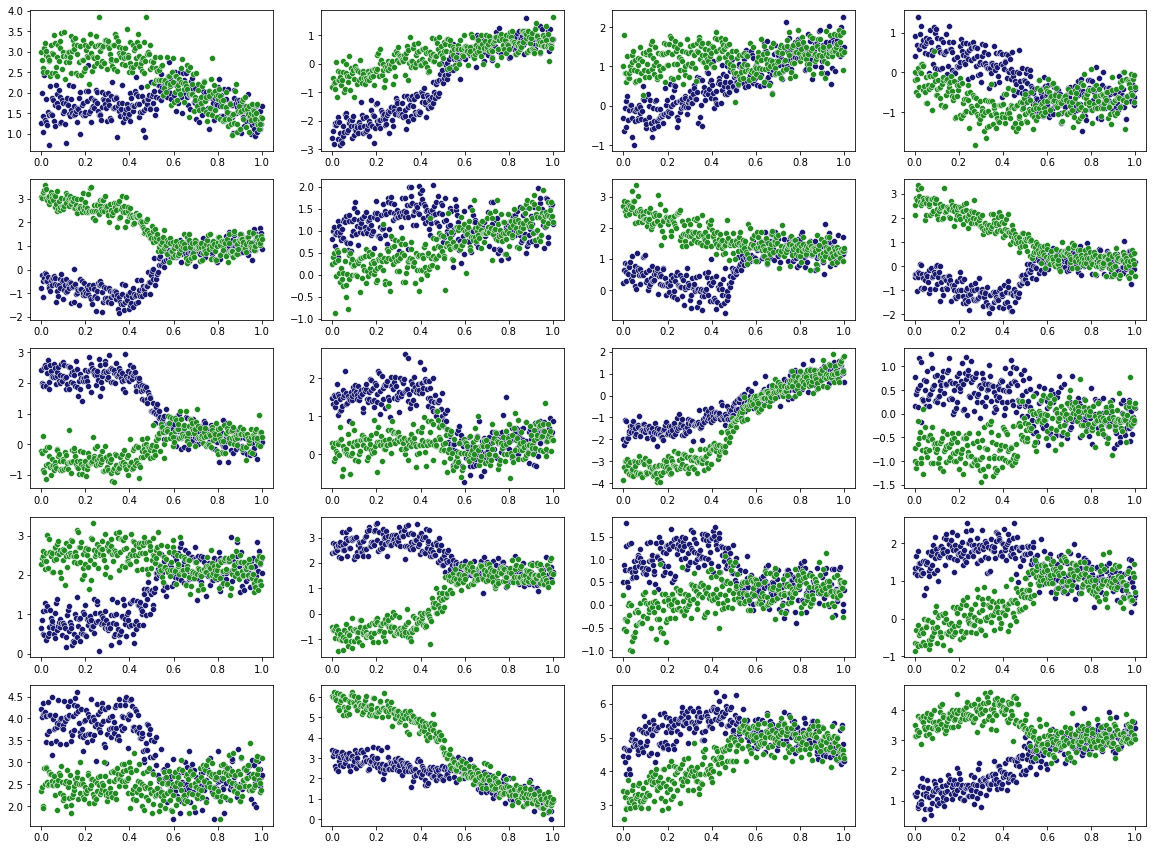

In [89]:
#plot_simulated_dataset(divergence_simulated_datasets[0:20], T_f, figsize=(20,15))
plot_simulated_dataset(convergence_simulated_datasets[30:50], T_f, figsize=(20,15)) 

# Crossing Simulator

In [78]:
torch.manual_seed(1)
def get_branching_kernel(T_f, BIFURCATION_POINT = 0.5, plot_kernels = False):

    K = gpytorch.kernels.RBFKernel(); K.lengthscale = 0.5 # define kernel
    n_functions = 2
    bifurcation_t = torch.tensor(BIFURCATION_POINT) 
    K_ff = K(T_f).evaluate() # K_ff block -- self function variance -- evaluate covariance function for the sampled index timepoints
    k_fb = [] # vector of covariance function values for each index time point of the function with the intersection time point = K(T_f,t_b)
    for t in T_f:
        k_fb.append(K.forward(t,bifurcation_t).detach().numpy()[0][0])
    k_fb = torch.tensor(k_fb).unsqueeze(0)
    k_bb = K.forward(bifurcation_t,bifurcation_t).detach().numpy()[0][0] # variance of the intersection point 
    K_fg = torch.matmul(torch.transpose(k_fb,0,1),k_fb)/torch.tensor(k_bb)

    branching_kernel = gpytorch.lazy.NonLazyTensor(K_ff -  K_fg)
    
    K_diagonal_block = K_ff
    K_non_diagonal_block = K_fg
    
    # joint branching kernel -- the block kernel representation for the joint distribution of the 2 functions:
    rows = []
    for i in range(0,n_functions):
        row = []
        for j in range(0,n_functions):
            if(i==j):
                row.append(K_diagonal_block)
            else:
                row.append(K_non_diagonal_block)
        rows.append(torch.hstack(row))
    joint_branching_kernel = torch.vstack(rows)  

    if(plot_kernels):
        fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(15,5), gridspec_kw={'wspace':0.3},constrained_layout=False)
        axs[0].set_title('Branching kernel for GP')
        sb.heatmap(branching_kernel.evaluate().detach().numpy(),ax=axs[0]) # the covariance function (kernel) for sampling a function under the constraint that multiple samples will intersect at the point
        axs[1].set_title('joint Branching kernel')
        sb.heatmap(joint_branching_kernel.detach().numpy(), ax=axs[1])  
        
    return branching_kernel

def simulate_branching_process(sampled_functions, T_f, σ = 0.1): # generate random data points according to the Hierarhical GP branching process
    simulated_data = []
    for f in sampled_functions[0:len(sampled_functions)]:
        sample = gpytorch.distributions.MultivariateNormal(f, (σ**2)*torch.eye(len(f))).rsample()
        simulated_data.append(sample)
    return simulated_data

def get_datasets(T_f, simulated_data, sampled_functions, MEAN_DIFF_THRESHOLD = 0.5):
    datasets = []
    for i in range(len(simulated_data)):
        for j in range(len(simulated_data)):
            if(i==j):
                continue
            x = simulated_data[i].detach().numpy()
            y = simulated_data[j].detach().numpy()
            if( np.abs(np.mean(x[0])-np.mean(y[0]))>MEAN_DIFF_THRESHOLD and  np.abs(np.mean(x[len(x)-1])-np.mean(y[len(y)-1]))>MEAN_DIFF_THRESHOLD ): 
            #if(mean_diff > MEAN_DIFF_THRESHOLD):
                datasets.append([x,y])
                continue
    return datasets

def plot_crossing_pairs(simulated_datasets, T_f, figsize=(20,60) ):
    l = len(simulated_datasets)
    ncol = 4
    nrow = int(np.ceil((l)/ncol)) 
    plt.subplots(nrow,ncol,figsize=figsize)
    k=1
    print(nrow,ncol)
    for i in range(len(simulated_datasets)):
                plt.subplot(nrow,ncol,k)
                sb.scatterplot(T_f,simulated_datasets[i][0], color='midnightblue')
                sb.scatterplot(T_f,simulated_datasets[i][1], color='forestgreen')
                k=k+1

def run_crossing_simulator(T_f, BIFURCATION_POINT = 0.5, n_simulations = 5, σ = 0.1,MEAN_DIFF_THRESHOLD=0.5):
    
    branching_kernel = get_branching_kernel(T_f, BIFURCATION_POINT = BIFURCATION_POINT)
    
    MVN = gpytorch.distributions.MultivariateNormal(mean = torch.zeros(len(T_f)),covariance_matrix = branching_kernel)
    sampled_functions = []
    print('n_sims = ', n_simulations)
    for i in range(0,n_simulations):
        function = MVN.rsample()
        sb.scatterplot(T_f.numpy(),function.detach().numpy() )
        sampled_functions.append(function)
        
    simulated_data = simulate_branching_process(sampled_functions, T_f, σ)
    return get_datasets(T_f, simulated_data, sampled_functions,MEAN_DIFF_THRESHOLD )
        
#cross_simulated_datasets = run_crossing_simulator(T_f, n_simulations=25,σ=0.2, MEAN_DIFF_THRESHOLD=1.0)
#plot_crossing_pairs(cross_simulated_data[0:20],T_f, figsize=(20,10))

5 4


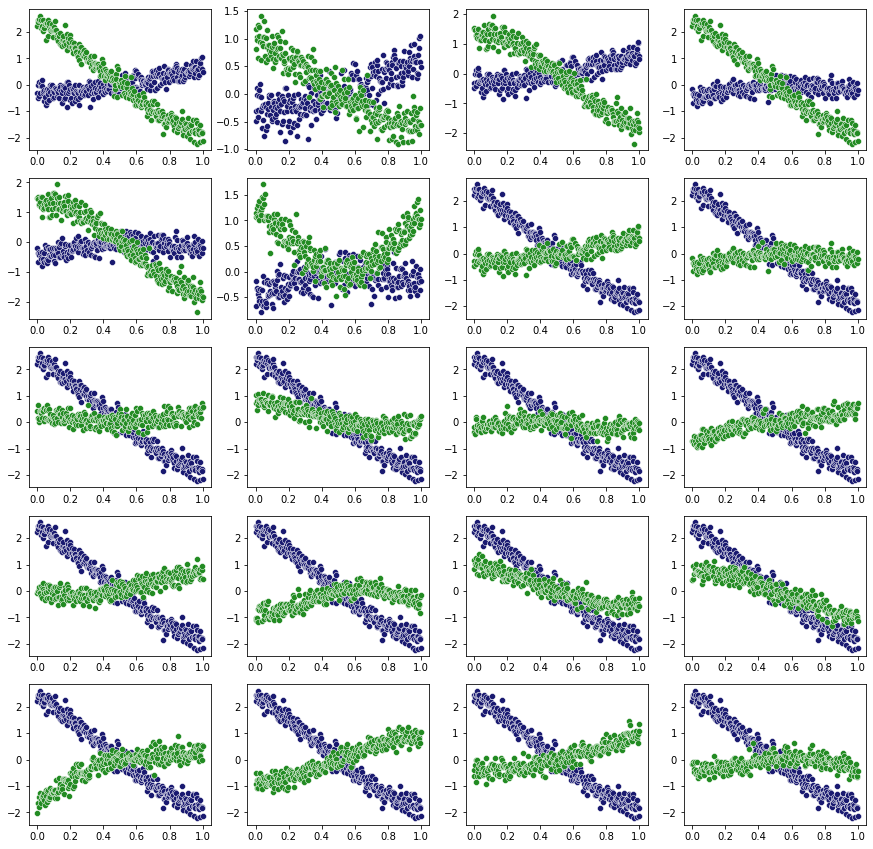

In [82]:
plot_crossing_pairs(cross_simulated_datasets[0:20],T_f, figsize=(15,15))

In [25]:
#import pickle
#pickle.dump(matched_datasets, open('/nfs/team205/ds40/G2G/SimulatedDataWithGP/match_simulated_datasets.pkl', 'wb')) 
#pickle.dump(divergence_simulated_datasets, open('/nfs/team205/ds40/G2G/SimulatedDataWithGP/divergence_simulated_datasets.pkl', 'wb')) 
#pickle.dump(convergence_simulated_datasets, open('/nfs/team205/ds40/G2G/SimulatedDataWithGP/convergence_simulated_datasets.pkl', 'wb')) 
#pickle.dump(cross_simulated_datasets, open('/nfs/team205/ds40/G2G/SimulatedDataWithGP/cross_simulated_datasets.pkl', 'wb')) 

### Running G2G on simulated data and evaluating

In [28]:
aligner_divergence = run_G2G(divergence_simulated_datasets,T_f)

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
aligner_convergence = run_G2G(convergence_simulated_datasets, T_f)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
# ----- For divergence and convergence validation ------------

def evaluate_divConv_alignments(aligner, divergence=True): 

    start_terminal_match_count_dist = []
    start_terminal_mismatch_count_dist = []
    end_terminal_mimatch_count_dist = [] 
    total_match_cout_dist = []

    for i in range(len(aligner.gene_list)):
        al_str = aligner.results[i].alignment_str
        #print(al_str)
        if(not divergence):
            al_str = aligner.results[i].alignment_str[::-1]
        c=0
        start_state = al_str[0]

        # Expecting match at the start 
        start_terminal_match_count = 0
        start_terminal_mismatch_count = 0
        start_state = al_str[0]

        # If there is a mismatch at the start, record the length
        if(start_state in ['I','D']):
            while(al_str[c] in ['I','D']):
                start_terminal_mismatch_count =  start_terminal_mismatch_count+1
                c+=1
            first_m_idx= al_str.find('M')
            first_w_idx = al_str.find('W')
            first_v_idx = al_str.find('V')
            temp =np.asarray([first_m_idx, first_w_idx, first_v_idx]) 
            temp[temp<0] = 10000 # some max number to filter out negative values when there is an absence of a state
            # find which comes first and start counting matches from there
            t  = np.argmin(temp)
            c = temp[t]
        else:
            while(al_str[c] not in ['I','D']):
                start_terminal_match_count = start_terminal_match_count + 1
                c += 1

        # Expecting a mismatch at the end
        al_str_reversed = al_str[::-1] 
        end_terminal_mismatch_count = 0

        first_m_idx= al_str_reversed.find('M')
        if(first_m_idx!=0):
            I_len = al_str_reversed[0:first_m_idx].count('I')
            D_len = al_str_reversed[0:first_m_idx].count('D')
            end_terminal_mismatch_count = np.max([D_len, I_len])

        start_terminal_match_count_dist.append(start_terminal_match_count)
        start_terminal_mismatch_count_dist.append(start_terminal_mismatch_count)
        end_terminal_mimatch_count_dist.append(end_terminal_mismatch_count)
        total_match_cout_dist.append( (al_str.count('M') + al_str.count('W') + al_str.count('V')))
        
        #print(start_terminal_mismatch_count, start_terminal_match_count, end_terminal_mismatch_count)
    return start_terminal_match_count_dist, start_terminal_mismatch_count_dist, end_terminal_mimatch_count_dist

def run_diveConv_experiment(aligner, divergence):
    if(not divergence):
        end_terminal_match_count_dist, end_terminal_mismatch_count_dist, start_terminal_mimatch_count_dist = evaluate_divConv_alignments(aligner, divergence=False)
        df = pd.DataFrame([end_terminal_match_count_dist, end_terminal_mismatch_count_dist, start_terminal_mimatch_count_dist]).transpose()
        df.columns = ['end_terminal_match_len', 'end_terminal_mismatch_len', 'start_terminal_mismatch_len']
    else:
        start_terminal_match_count_dist, start_terminal_mismatch_count_dist, end_terminal_mimatch_count_dist = evaluate_divConv_alignments(aligner)
        df = pd.DataFrame([start_terminal_match_count_dist, start_terminal_mismatch_count_dist, end_terminal_mimatch_count_dist]).transpose()
        df.columns = ['start_terminal_match_len', 'start_terminal_mismatch_len', 'end_terminal_mismatch_len']
    
    sb.boxplot(data=df, orient='h', flierprops={"marker": "x"})

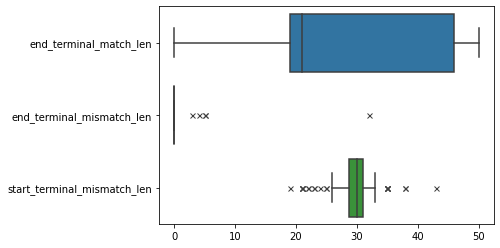

In [32]:
run_diveConv_experiment(aligner_convergence, divergence = False)

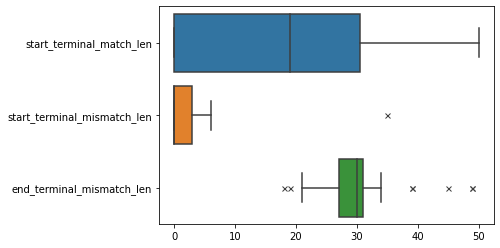

In [33]:
run_diveConv_experiment(aligner_divergence, divergence = True)

In [48]:
# for cross pattern alignment validation
def get_match_len(al_str):
    
        first_m_idx = al_str.find('M')
        first_w_idx = al_str.find('W')
        first_v_idx = al_str.find('V')
        temp =np.asarray([first_m_idx, first_w_idx, first_v_idx]) 
        temp[temp<0] = 10000 # some max number to filter out negative values when there is an absence of a state
        # find which comes first and start counting matches from there
        c = temp[ np.argmin(temp)]
        match_idx = c
        
        match_len = 0
        while(al_str[c] in ['M','W','V']):
            match_len+=1
            c+=1
            
        return match_len, match_idx

def evaluate_crossing_alignments(aligner): 

    fwd_match_len_dist = []
    bwd_match_len_dist = []
    middle_indel_len_dist = []
    fwd_match_idx_dist = []
    bwd_match_idx_dist = []
    
    for i in range(len(aligner.gene_list)):
        al_str = aligner.results[i].alignment_str
        #print(aligner.results[i].gene)
        
        # fwd direction
        fwd_match_len, fwd_match_idx = get_match_len(al_str)
        fwd_match_len_dist.append(fwd_match_len)
        fwd_match_idx_dist.append(fwd_match_idx)
        
        #print(al_str, fwd_match_len, fwd_match_idx)
        
        # bwd direction 
        bwd_match_len, bwd_match_idx = get_match_len(al_str[::-1])
        bwd_match_len_dist.append(bwd_match_len)
        bwd_match_idx_dist.append(bwd_match_idx)
        
        #print(al_str, bwd_match_len, bwd_match_idx)
        
        if(len(al_str) - (fwd_match_idx + fwd_match_len) == bwd_match_idx): # if this is true --> there are no indels occured in the middle
            continue
            
        # if indels, occured the length of that part from fwd 
        #print(fwd_match_idx, fwd_match_len, len(al_str))
        c = fwd_match_idx + fwd_match_len
        middle_indel_len = 0
       # print(al_str[c])
        while(c<len(al_str) and al_str[c] in ['I','D']):
            middle_indel_len+=1
            c+=1
        #print(middle_indel_len)
        middle_indel_len_dist.append(middle_indel_len)
    
    return fwd_match_len_dist, fwd_match_idx_dist, bwd_match_len_dist, bwd_match_idx_dist, middle_indel_len_dist


def run_crossing_experiment(aligner):
    plt.subplots(1,2, figsize=(10,3))
    plt.subplot(1,2,1)
    fwd_match_len_dist, fwd_match_idx_dist, bwd_match_len_dist, bwd_match_idx_dist, middle_indel_len_dist = evaluate_crossing_alignments(aligner)
    df = pd.DataFrame([fwd_match_len_dist, fwd_match_idx_dist, bwd_match_len_dist, bwd_match_idx_dist]).transpose() 
    df.columns = ['fwd_match_len', 'fwd_match_idx', 'bwd_match_len', 'bwd_match_idx']
    sb.boxplot(data=df, orient='h', flierprops={"marker": "x"})
    plt.subplot(1,2,2)
    sb.boxplot(data=middle_indel_len_dist, orient='h', flierprops={"marker": "x"})
    plt.title('Indel lengths in the middle')

In [79]:
cross_simulated_datasets = cross_simulated_datasets[0:100] 

In [50]:
aligner_cross = run_G2G(cross_simulated_datasets[0:100], T_f)

  0%|          | 0/100 [00:00<?, ?it/s]

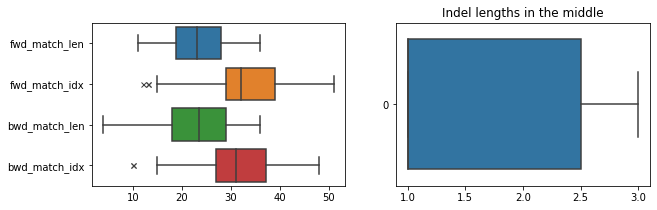

In [51]:
run_crossing_experiment(aligner_cross)

# Run G2G for all patterns together

In [80]:
with open('/nfs/team205/ds40/G2G/SimulatedDataWithGP/aligner_all.pkl', 'rb') as f:
         aligner = pickle.load(f)
with open('/nfs/team205/ds40/G2G/SimulatedDataWithGP/match_simulated_datasets.pkl', 'rb') as f:
         matched_datasets = pickle.load(f)
with open('/nfs/team205/ds40/G2G/SimulatedDataWithGP/divergence_simulated_datasets.pkl', 'rb') as f:
         divergence_simulated_datasets = pickle.load(f)
with open('/nfs/team205/ds40/G2G/SimulatedDataWithGP/convergence_simulated_datasets.pkl', 'rb') as f:
         convergence_simulated_datasets = pickle.load(f)
with open('/nfs/team205/ds40/G2G/SimulatedDataWithGP/cross_simulated_datasets.pkl', 'rb') as f:
         cross_simulated_datasets = pickle.load(f)

In [4]:
pattern_labels = list(np.repeat('Divergence', len(divergence_simulated_datasets))) + list(np.repeat('AllMatch', len(matched_datasets))) + list(np.repeat('Convergence', len(convergence_simulated_datasets))) + list(np.repeat('Crossing', len(cross_simulated_datasets)))

In [5]:
cross_simulated_datasets = cross_simulated_datasets[0:100] 
simulated_data = divergence_simulated_datasets + matched_datasets + convergence_simulated_datasets + cross_simulated_datasets
T_f = torch.tensor(np.linspace(0,1,300,dtype=np.float64)) # specify time points 

In [6]:
aligner_all = run_G2G(simulated_data,T_f, use_const_std=False)
for a in aligner_all.results:
    aligner_all.pairs[a.gene] = [a.S, a.T]

  0%|          | 0/400 [00:00<?, ?it/s]

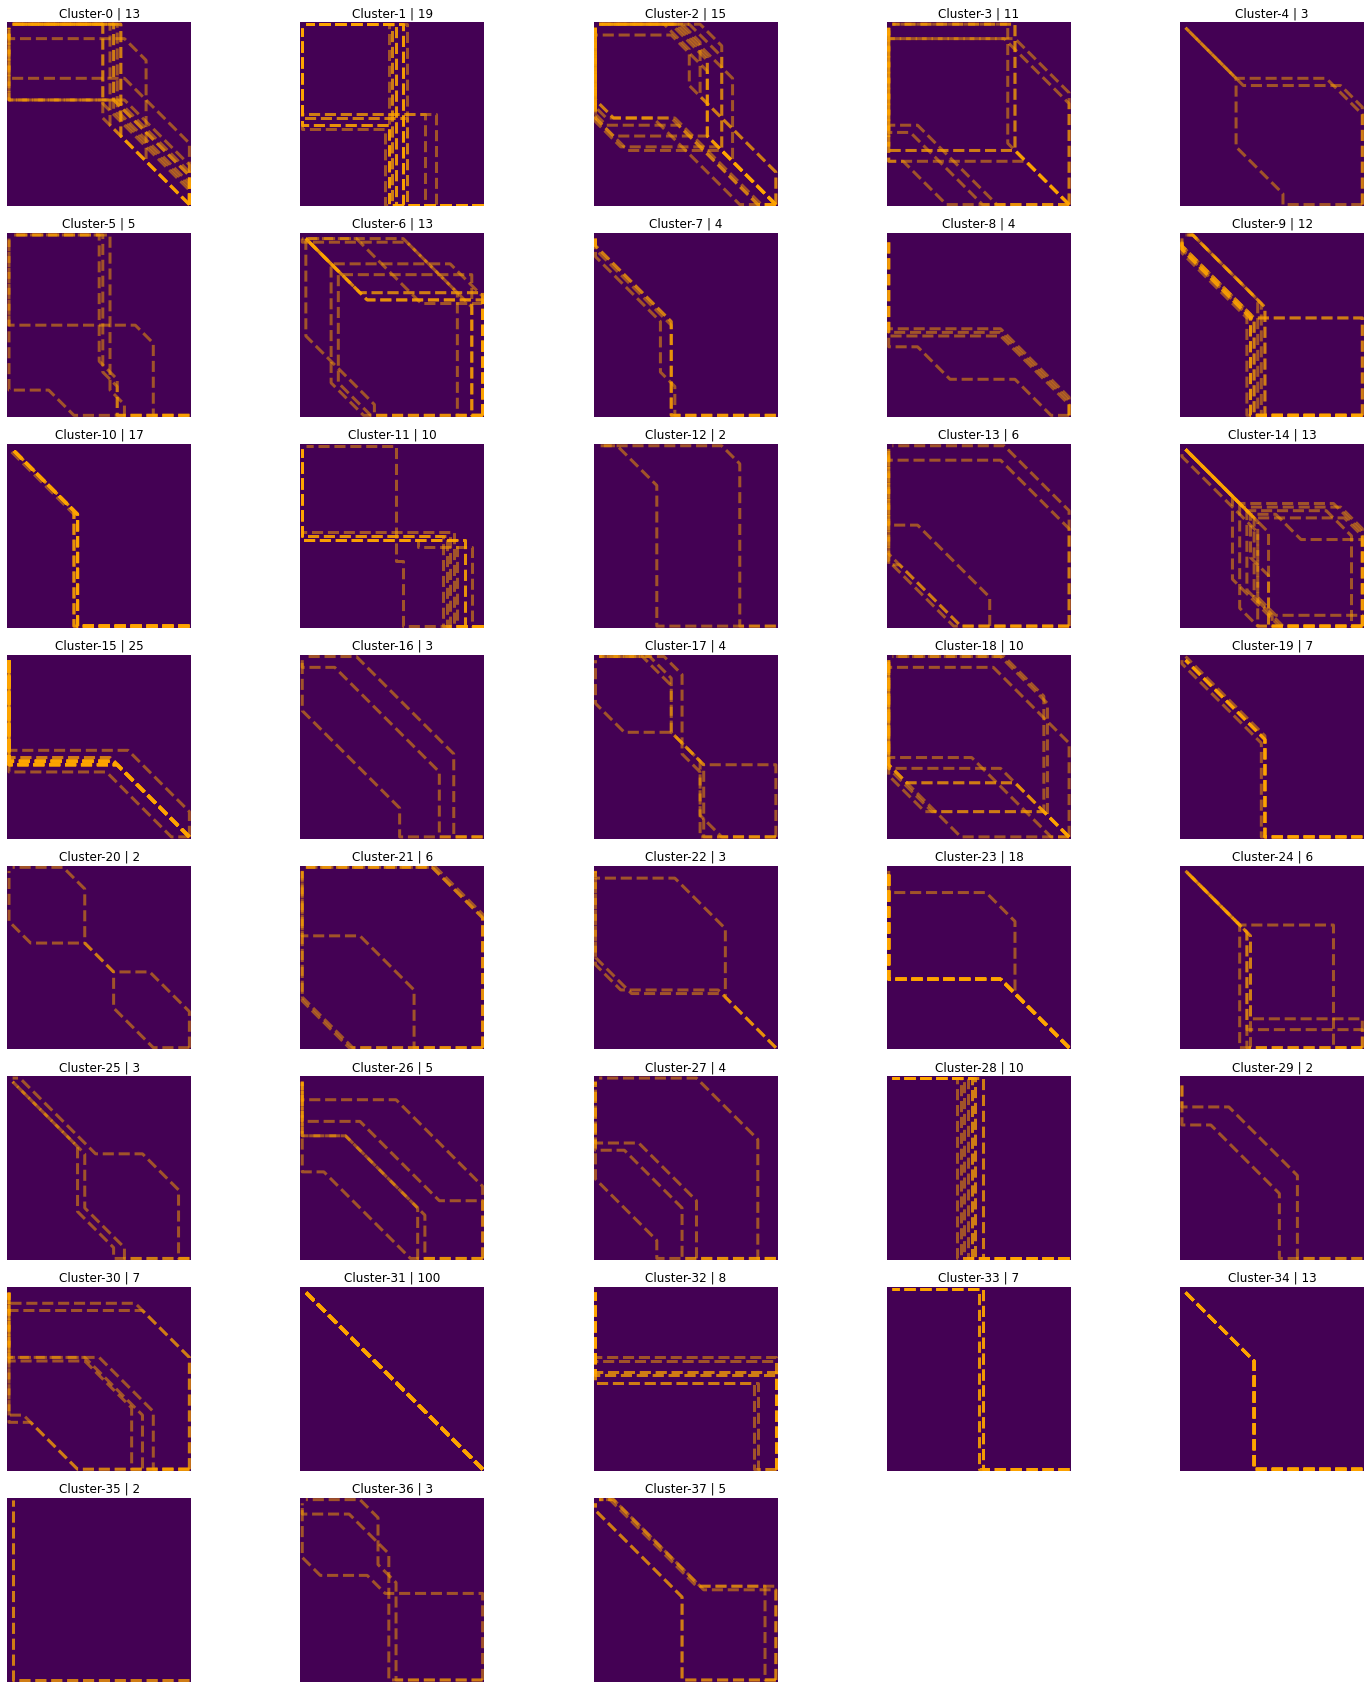

In [8]:
ClusterUtils.run_hierarchical_clustering(aligner_all)

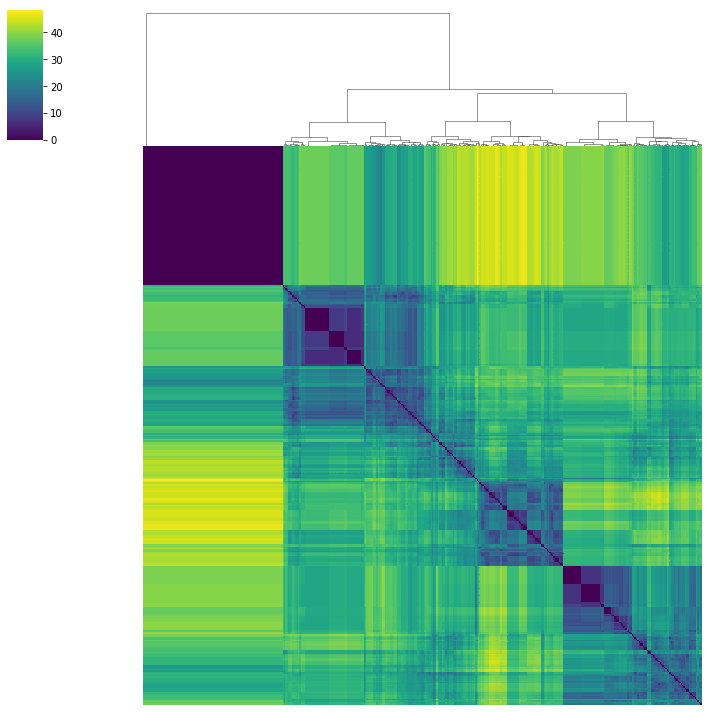

In [99]:
p = sb.clustermap(aligner_all.DistMat,cmap='viridis', method='ward',yticklabels=False,xticklabels=False)
p.ax_row_dendrogram.set_visible(False) 

In [104]:
np.asarray(pattern_labels)[p.dendrogram_row.reordered_ind][0:100] 

array(['AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch',
       'AllMatch', 'AllMatch', 'AllMatch', 'AllMatch', 'AllMat

### Checking alignment pattern composition of each cluster

In [121]:
def cluster_stat(aligner):
    
    Div = []; AllM = []; Conv=[]; Cross=[]; n_genes=[]
    Pure = []
    for i in range(len(aligner.gene_clusters)):
        cluster_patterns = [] 
        cluster = aligner.gene_clusters[i]
        for j in cluster:
            #print(j, pattern_labels[int(j.split('Gene')[1])], aligner.results_map[j].alignment_str)
            cluster_patterns.append(pattern_labels[int(j.split('Gene')[1])])
        #print(i, np.unique(cluster_patterns, return_counts=True))

        Div.append(cluster_patterns.count('Divergence')/len(cluster)) 
        AllM.append(cluster_patterns.count('AllMatch')/len(cluster)) 
        Conv.append(cluster_patterns.count('Convergence')/len(cluster)) 
        Cross.append(cluster_patterns.count('Crossing')/len(cluster)) 
        n_genes.append(len(cluster)) 
        if(len(np.unique(cluster_patterns, return_counts=True)[0])>1):
            Pure.append('N')
        else:
            Pure.append('Y')

    df = pd.DataFrame([n_genes, AllM, Div, Conv, Cross, Pure]).transpose()
    df.columns = ['nGenes', 'AllMatch','Divergence','Convergence','Crossing','Pure_cluster']
    return df 

In [123]:
df_aligner_all = cluster_stat(aligner_all)
df_aligner_all


,nGenes,AllMatch,Divergence,Convergence,Crossing,Pure_cluster
0,13,0.0,0.0,1.0,0.0,Y
1,19,0.0,0.0,0.0,1.0,Y
2,15,0.0,0.0,1.0,0.0,Y
3,11,0.0,0.0,1.0,0.0,Y
4,3,0.0,1.0,0.0,0.0,Y
5,5,0.0,0.0,0.2,0.8,N
6,13,0.0,1.0,0.0,0.0,Y
7,4,0.0,1.0,0.0,0.0,Y
8,4,0.0,0.0,1.0,0.0,Y
9,12,0.0,1.0,0.0,0.0,Y


In [124]:
df_aligner_all[df_aligner_all['Pure_cluster'] == 'N'] 

,nGenes,AllMatch,Divergence,Convergence,Crossing,Pure_cluster
5,5,0.0,0.0,0.2,0.8,N


In [116]:
df_aligner_all.to_csv('df_aligner_all.csv')

In [52]:
# E.g. of extreme divergence case where g2g misses many matches at the beginning in the non constant std (default) mode -- this gives correct alignment when const std is used 
#aligner_all.results[81].plotTimeSeries(aligner_all, plot_cells=True)
#aligner_all.results[81].plotTimeSeriesAlignment() 

### Exploring Clustering output for n_clusters = 4 

In [42]:
def plot_cluster_patterns(E):
    # agglomerative clustering
    clustering = AgglomerativeClustering(n_clusters=4, linkage='ward', affinity='euclidean').fit(E)
    k = pd.DataFrame([pattern_labels,clustering.labels_]).transpose()
    k.columns = ['pattern','cluster_id']
    print(np.unique(k[k.cluster_id==0]['pattern'], return_counts=True)) 
    print(np.unique(k[k.cluster_id==1]['pattern'], return_counts=True)) 
    print(np.unique(k[k.cluster_id==2]['pattern'], return_counts=True))
    print(np.unique(k[k.cluster_id==3]['pattern'], return_counts=True)) 

    k['COUNTER'] = 1
    k = k.groupby(['cluster_id','pattern'])['COUNTER'].sum().unstack()
    k = k.fillna(0)
    p = k.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True, color=sb.color_palette('tab20', 20))
    p.legend(loc='center left', bbox_to_anchor=(1.0, 0.85), ncol=1)
    plt.title('Agglomerative Clustering')
    # kmeans clustering
    clustering = KMeans(n_clusters=4, random_state=0).fit(E)
    k = pd.DataFrame([pattern_labels,clustering.labels_]).transpose()
    k.columns = ['pattern','cluster_id']
    print(np.unique(k[k.cluster_id==0]['pattern'], return_counts=True)) 
    print(np.unique(k[k.cluster_id==1]['pattern'], return_counts=True)) 
    print(np.unique(k[k.cluster_id==2]['pattern'], return_counts=True))
    print(np.unique(k[k.cluster_id==3]['pattern'], return_counts=True)) 

    k['COUNTER'] = 1
    k = k.groupby(['cluster_id','pattern'])['COUNTER'].sum().unstack()
    k = k.fillna(0)
    p = k.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True, color=sb.color_palette('tab20', 20))
    p.legend(loc='center left', bbox_to_anchor=(1.0, 0.85), ncol=1)
    plt.title('K-means Clustering')
    

(array(['Convergence', 'Crossing'], dtype=object), array([99, 42]))
(array(['Convergence', 'Crossing', 'Divergence'], dtype=object), array([ 1, 58,  4]))
(array(['Divergence'], dtype=object), array([96]))
(array(['AllMatch'], dtype=object), array([100]))
(array(['AllMatch'], dtype=object), array([100]))
(array(['Convergence', 'Crossing'], dtype=object), array([99, 13]))
(array(['Crossing', 'Divergence'], dtype=object), array([ 6, 97]))
(array(['Convergence', 'Crossing', 'Divergence'], dtype=object), array([ 1, 81,  3]))


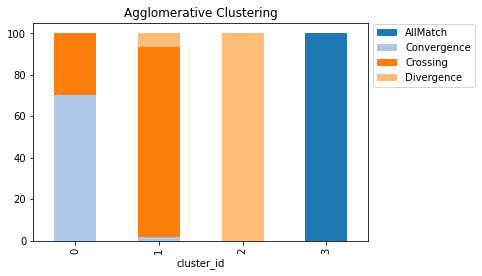

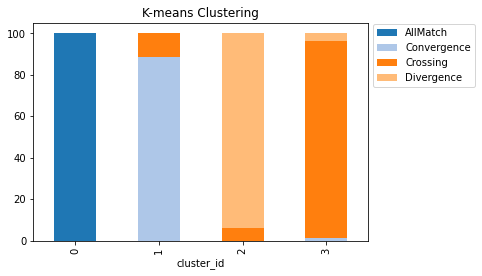

In [105]:
plot_cluster_patterns(aligner_all.E)